/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw      q_mvar
0  1.000000   0.000000 -228.815945 -550.429472
1  0.846296 -37.942907    0.000000    0.000000
2  0.821273 -38.821199   45.000000   30.000000
3  0.796834 -39.737782   52.500000   35.000000
4  0.784815 -40.221919   22.500000   15.000000
5  0.781776 -40.298888   90.000000   60.000000
6  0.830803 -38.530950    0.000000    0.000000


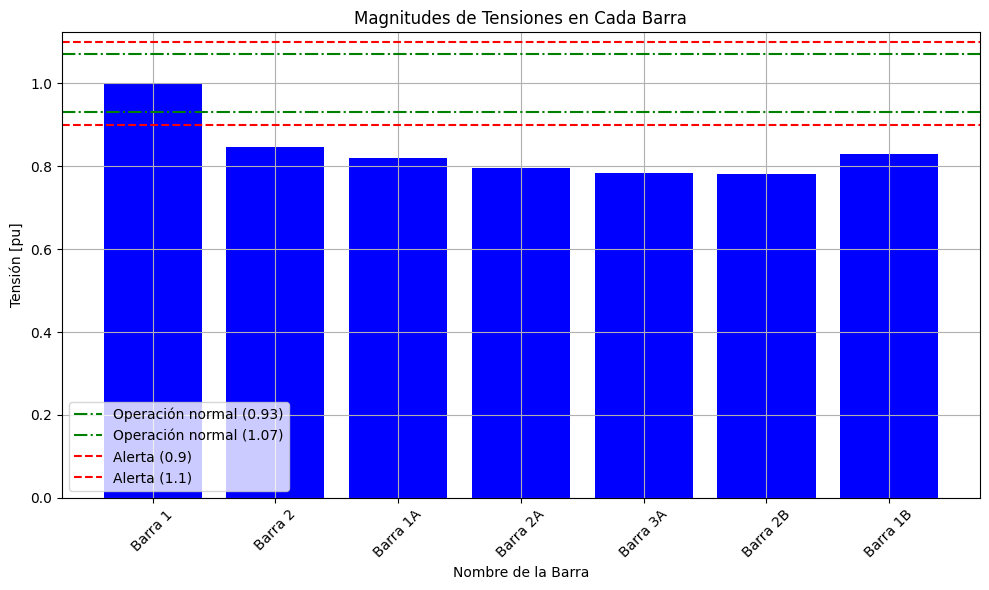

In [1]:


import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import math

# Para la creación de este modelo se asume un sistema trifásico, con voltaje linea-linea de 220[kV],
# analizamos el circuito equivalente para 1 fase

# Definimos los parámetros
f = 50  # frecuencia del sistema en [Hz]

Vg_LL = 110  # voltaje de la línea en [kV]
Imax = 0.457  # corriente máxima en las líneas [kA]

# Respecto a la carga
P = 150  # potencia activa en [MW]
Q = 100  # potencia reactiva en [Mvar]

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es designada como slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2")  # Barra 2 se conecta la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1A")  # Barra 1A se conecta la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2A")  # Barra 2A se conecta la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 3A")  # Barra 3A se conecta la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2B")  # Barra 2B se conecta la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1B")  # Barra 1B se conecta la carga

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga
pp.create_load(net, bus=bus1A, p_mw=0.2*P, q_mvar=0.2*Q)
pp.create_load(net, bus=bus2A, p_mw=0.35*P, q_mvar=0.35*Q)
pp.create_load(net, bus=bus3A, p_mw=0.15*P, q_mvar=0.15*Q)
pp.create_load(net, bus=bus2B, p_mw=0.6*P, q_mvar=0.6*Q)
pp.create_load(net, bus=bus1A, p_mw=0.1*P, q_mvar=0.1*Q)

# Se añade fuente de generación conectada en la barra 1, (1[pu], el voltaje nominal [kV] se define en la barra a la que está conectada)
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Se añade transformador de 100 MVA 220/110 kV entre la barra 1 y la barra 2
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")
net.trafo.tap_phase_shifter = net.trafo.tap_phase_shifter.fillna(value=False)


# Simular el flujo de carga
pp.runpp(net)

# Imprimir resultados de las barras
print(net.res_bus)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Agregar línea segmentada para el rango de operación normal (0.93 - 1.07)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')

# Agregar línea segmentada para el rango de alerta (0.9 - 1.1)
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [2]:



# Obtener resultados de las corrientes de línea en kA
corrientes_linea = np.abs(net.res_line.loading_percent.values * net.line.i_ka.values / 100.0)  # Convertir a kA
nombres_lineas = [f'Línea {i+1}' for i in range(len(corrientes_linea))]  # Nombres de las líneas

# Crear la lista de corrientes para el gráfico de barras
valores_barras = corrientes_linea

# Colores para las barras (rojo si está saturada, verde si no)
colores = ['red' if corrientes_linea[i] > Imax else 'green' for i in range(len(corrientes_linea))]

# Graficar barras de corrientes de línea
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_lineas, valores_barras, color=colores)

# Agregar línea segmentada para la corriente máxima de línea (0.457 kA)
plt.axhline(y=Imax, color='blue', linestyle='--', label=f'Corriente máxima de línea ({Imax} kA)')

plt.title('Corrientes de Línea')
plt.xlabel('Línea')
plt.ylabel('Corriente [kA]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'i_ka'